In [1]:
# Prophet is sometimes not installed by default

%pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

# Load processed dataset (
df = pd.read_csv("../data/processed/superstore_processed.csv")

# Convert date column again 
df["Order Date"] = pd.to_datetime(df["Order Date"])

df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,26196.0,2,0.00,419136.0
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",73194.0,3,0.00,219582.0
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,1462.0,2,0.00,68714.0
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,9575775.0,5,0.45,-383031.0
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22368.0,2,0.20,25164.0


In [3]:

# Aggregate sales by month
monthly_sales = (
    df
    .set_index("Order Date")     # use Order Date as time index
    .resample("ME")               # monthly aggregation
    .agg({"Sales": "sum"})       # sum of sales per month
    .reset_index()
)

# Rename columns for Prophet
monthly_sales.columns = ["ds", "y"]

monthly_sales.head()


,ds,y
0,2014-01-31,2908640.0
1,2014-02-28,799427.0
2,2014-03-31,19889225.0
3,2014-04-30,8814899.0
4,2014-05-31,9349645.0


In [4]:
# Use last 6 months as test data
train = monthly_sales.iloc[:-6]
test = monthly_sales.iloc[-6:]

train.tail(), test.head()


(           ds           y
 37 2017-02-28   9422108.0
 38 2017-03-31  19745364.0
 39 2017-04-30  26154734.0
 40 2017-05-31  23672262.0
 41 2017-06-30  33930631.0,
            ds           y
 42 2017-07-31  17083940.0
 43 2017-08-31  36555534.0
 44 2017-09-30  42524652.0
 45 2017-10-31  40959473.0
 46 2017-11-30  54703111.0)

In [5]:
from prophet import Prophet

# Initialize Prophet model
model = Prophet(
    yearly_seasonality=True,   # yearly sales patterns
    weekly_seasonality=False,  # not useful for monthly data
    daily_seasonality=False
)

# Train the model
model.fit(train)


13:06:23 - cmdstanpy - INFO - Chain [1] start processing
13:06:23 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Create future dates (6 months ahead)
future = model.make_future_dataframe(periods=6, freq="ME")

# Generate forecast
forecast = model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
43,2017-08-31,2.617620e+07,2.066149e+07,3.195501e+07
44,2017-09-30,5.825392e+07,5.270677e+07,6.397161e+07
45,2017-10-31,2.130266e+07,1.566108e+07,2.710066e+07
46,2017-11-30,4.847368e+07,4.267994e+07,5.455696e+07
47,2017-12-31,4.048965e+07,3.461731e+07,4.595860e+07


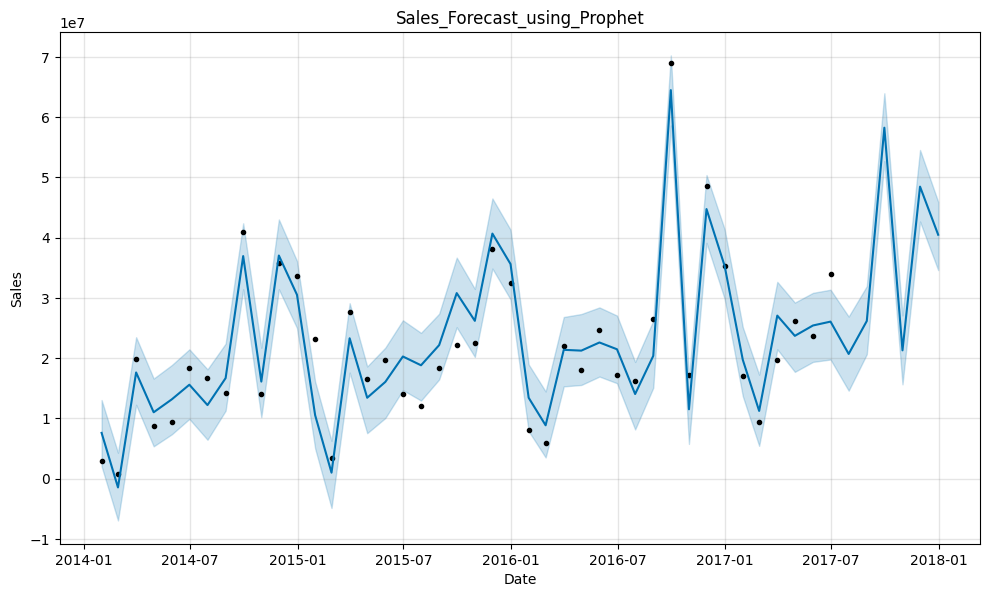

In [7]:
# Plot forecast
import matplotlib.pyplot as plt
model.plot(forecast)
plt.title("Sales_Forecast_using_Prophet")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [8]:
from sklearn.metrics import mean_absolute_percentage_error

# Extract predictions for test period
test_forecast = forecast.iloc[-6:]["yhat"].values
actuals = test["y"].values

# Calculate MAPE
mape = mean_absolute_percentage_error(actuals, test_forecast) * 100

print(f"MAPE: {mape:.2f}%")


MAPE: 27.80%


## Phase D: Segment-wise Sales Forecasting


In [13]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,26196.0,2,0.00,419136.0
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",73194.0,3,0.00,219582.0
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,1462.0,2,0.00,68714.0
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,9575775.0,5,0.45,-383031.0
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22368.0,2,0.20,25164.0


In [15]:
import numpy as np
import pandas as pd

# Define analysis date
analysis_date = df["Order Date"].max() + pd.Timedelta(days=1)

# Build RFM table
rfm = (
    df.groupby("Customer ID")
    .agg({
        "Order Date": lambda x: (analysis_date - x.max()).days,
        "Order ID": "nunique",
        "Sales": "sum"
    })
    .reset_index()
)

rfm.columns = ["Customer ID", "Recency", "Frequency", "Monetary"]

rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,AA-10315,185,5,5090484.0
1,AA-10375,20,9,165678.0
2,AA-10480,260,4,193048.0
3,AA-10645,56,6,1737756.0
4,AB-10015,416,3,143818.0


In [17]:
# Log transform monetary to reduce skew
rfm["Monetary"] = np.log1p(rfm["Monetary"])

# Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(
    rfm[["Recency", "Frequency", "Monetary"]]
)

rfm_scaled.shape


(793, 3)

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm["Cluster"].value_counts()


Cluster
3    346
0    296
2     90
1     61
Name: count, dtype: int64

In [20]:
cluster_map = {
    0: "Potential Loyalists",
    1: "At-Risk / Lost",
    2: "Champions",
    3: "Loyal Customers"
}

rfm["Customer_Segment"] = rfm["Cluster"].map(cluster_map)

rfm.head()


,Customer ID,Recency,Frequency,Monetary,Cluster,Customer_Segment
0,AA-10315,185,5,2.799893,3,Loyal Customers
1,AA-10375,20,9,2.566318,0,Potential Loyalists
2,AA-10480,260,4,2.577995,3,Loyal Customers
3,AA-10645,56,6,2.732294,3,Loyal Customers
4,AB-10015,416,3,2.555389,2,Champions


In [22]:
customer_financials = (
    df.groupby("Customer ID")
    .agg({
        "Profit": "sum",
        "Discount": "mean"
    })
    .reset_index()
)

rfm = rfm.merge(
    customer_financials,
    on="Customer ID",
    how="left"
)

rfm.head()


,Customer ID,Recency,Frequency,Monetary,Cluster,Customer_Segment,Profit_x,Discount_x,Profit_y,Discount_y
0,AA-10315,185,5,2.799893,3,Loyal Customers,-6775855.0,0.090909,-6775855.0,0.090909
1,AA-10375,20,9,2.566318,0,Potential Loyalists,2189580.0,0.080000,2189580.0,0.080000
2,AA-10480,260,4,2.577995,3,Loyal Customers,4358274.0,0.016667,4358274.0,0.016667
3,AA-10645,56,6,2.732294,3,Loyal Customers,2154130.0,0.063889,2154130.0,0.063889
4,AB-10015,416,3,2.555389,2,Champions,1293465.0,0.066667,1293465.0,0.066667


In [24]:
rfm.columns.tolist()


['Customer ID',
 'Recency',
 'Frequency',
 'Monetary',
 'Cluster',
 'Customer_Segment',
 'Profit_x',
 'Discount_x',
 'Profit_y',
 'Discount_y']

In [26]:

if "Profit" not in rfm.columns:
    # Create clean Profit/Discount from one of the merged copies
    if "Profit_x" in rfm.columns:
        rfm["Profit"] = rfm["Profit_x"]
        rfm["Discount"] = rfm["Discount_x"]
    elif "Profit_y" in rfm.columns:
        rfm["Profit"] = rfm["Profit_y"]
        rfm["Discount"] = rfm["Discount_y"]

# Drop duplicate columns if they exist
cols_to_drop = [c for c in ["Profit_x", "Discount_x", "Profit_y", "Discount_y"] if c in rfm.columns]
rfm = rfm.drop(columns=cols_to_drop)

rfm.columns.tolist()


['Customer ID',
 'Recency',
 'Frequency',
 'Monetary',
 'Cluster',
 'Customer_Segment',
 'Profit',
 'Discount']

In [28]:
# Re-check cluster behavior (this determines the correct segment names)
cluster_summary = (
    rfm.groupby("Cluster")
    .agg({
        "Recency": "mean",
        "Frequency": "mean",
        "Monetary": "mean"
    })
    .round(2)
)

cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,75.25,8.90,2.73
1,188.80,3.07,2.44
2,569.89,4.03,2.64
3,92.85,5.27,2.66


In [30]:
# Automatically label clusters based on RFM logic (robust after kernel restarts)
ranked = cluster_summary.copy()

# For Recency: lower is better, so rank ascending
ranked["R_rank"] = ranked["Recency"].rank(ascending=True)
# For Frequency & Monetary: higher is better, so rank descending
ranked["F_rank"] = ranked["Frequency"].rank(ascending=False)
ranked["M_rank"] = ranked["Monetary"].rank(ascending=False)

# Combined score: lower rank numbers in all metrics = better
ranked["score"] = ranked["R_rank"] + ranked["F_rank"] + ranked["M_rank"]

# Identify best and worst clusters
champion_cluster = ranked["score"].idxmin()
atrisk_cluster = ranked["score"].idxmax()

# Label remaining two clusters
remaining = [c for c in ranked.index if c not in [champion_cluster, atrisk_cluster]]
# Decide which remaining is "Loyal" vs "Potential" based on Frequency (loyal buys more)
loyal_cluster = cluster_summary.loc[remaining, "Frequency"].idxmax()
potential_cluster = [c for c in remaining if c != loyal_cluster][0]

cluster_map = {
    int(champion_cluster): "Champions",
    int(loyal_cluster): "Loyal Customers",
    int(potential_cluster): "Potential Loyalists",
    int(atrisk_cluster): "At-Risk / Lost"
}

rfm["Customer_Segment"] = rfm["Cluster"].map(cluster_map)

rfm["Customer_Segment"].value_counts()


Customer_Segment
Loyal Customers        346
Champions              296
Potential Loyalists     90
At-Risk / Lost          61
Name: count, dtype: int64

In [32]:
# Merge customer segment labels into original dataset
df_segmented = df.merge(
    rfm[["Customer ID", "Customer_Segment"]],
    on="Customer ID",
    how="left"
)

# Validate
df_segmented[["Customer ID", "Customer_Segment"]].head()


,Customer ID,Customer_Segment
0,CG-12520,Potential Loyalists
1,CG-12520,Potential Loyalists
2,DV-13045,Loyal Customers
3,SO-20335,Champions
4,SO-20335,Champions


In [34]:
# Aggregate monthly sales for each customer segment
segment_monthly_sales = (
    df_segmented
    .set_index("Order Date")
    .groupby("Customer_Segment")
    .resample("ME")["Sales"]
    .sum()
    .reset_index()
)

segment_monthly_sales.head()


,Customer_Segment,Order Date,Sales
0,At-Risk / Lost,2014-01-31,3928.0
1,At-Risk / Lost,2014-02-28,17248.0
2,At-Risk / Lost,2014-03-31,10499.0
3,At-Risk / Lost,2014-04-30,65241.0
4,At-Risk / Lost,2014-05-31,0.0


In [35]:
# Focus on High-impact Segments
key_segments = ["Champions", "Loyal Customers"]

segment_monthly_sales = segment_monthly_sales[
    segment_monthly_sales["Customer_Segment"].isin(key_segments)
]


In [38]:
from prophet import Prophet

def forecast_segment(data, segment_name, periods=6):
    """
    Forecast monthly sales for a given customer segment.
    """
    # Filter specific segment
    segment_df = data[data["Customer_Segment"] == segment_name]

    # Rename columns for Prophet
    prophet_df = segment_df.rename(
        columns={"Order Date": "ds", "Sales": "y"}
    )[["ds", "y"]]

    # Train/test split
    train = prophet_df.iloc[:-periods]

    # Initialize Prophet model
    model = Prophet()
    model.fit(train)

    # Create future dates
    future = model.make_future_dataframe(periods=periods, freq="ME")

    # Forecast
    forecast = model.predict(future)

    return model, forecast


13:27:15 - cmdstanpy - INFO - Chain [1] start processing
13:27:15 - cmdstanpy - INFO - Chain [1] done processing


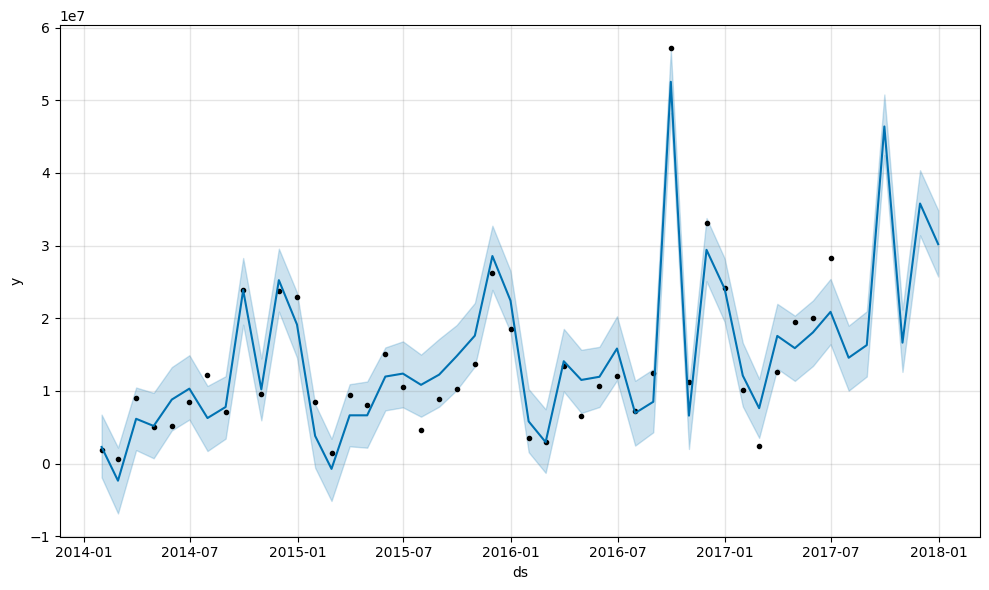

In [39]:
champion_model, champion_forecast = forecast_segment(
    segment_monthly_sales,
    "Champions"
)

champion_model.plot(champion_forecast);


13:28:33 - cmdstanpy - INFO - Chain [1] start processing
13:28:33 - cmdstanpy - INFO - Chain [1] done processing


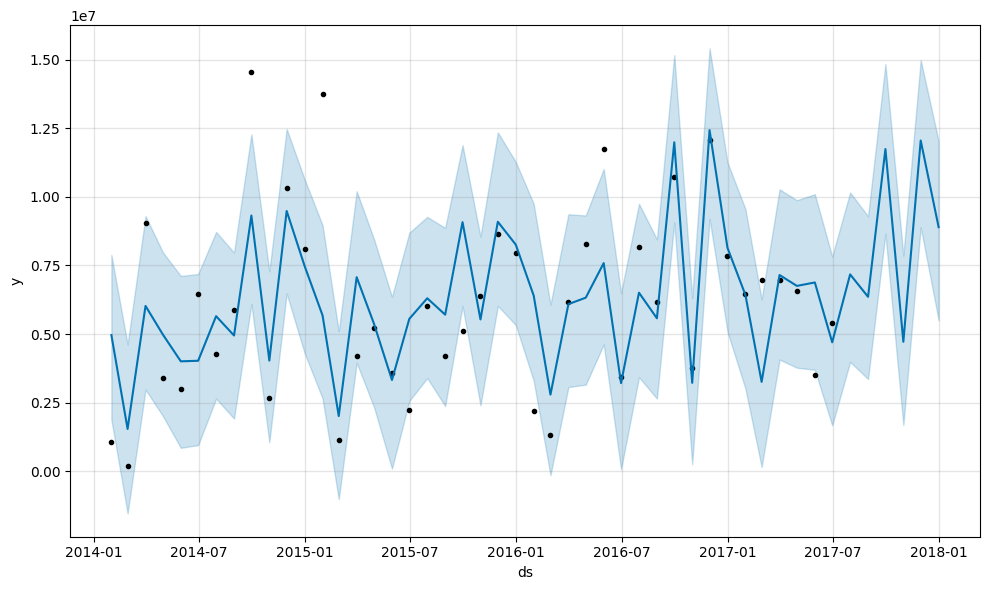

In [40]:
loyal_model, loyal_forecast = forecast_segment(
    segment_monthly_sales,
    "Loyal Customers"
)

loyal_model.plot(loyal_forecast);


In [41]:
# Extract only the future 6 months
champion_future = champion_forecast.tail(6)
loyal_future = loyal_forecast.tail(6)

# Total predicted sales over forecast horizon
champion_total = champion_future["yhat"].sum()
loyal_total = loyal_future["yhat"].sum()

total = champion_total + loyal_total

print("Champions Total Forecast:", round(champion_total, 2))
print("Loyal Customers Total Forecast:", round(loyal_total, 2))

print("\nContribution Split:")
print("Champions:", round((champion_total / total) * 100, 2), "%")
print("Loyal Customers:", round((loyal_total / total) * 100, 2), "%")


Champions Total Forecast: 159874800.75
Loyal Customers Total Forecast: 50939601.83

Contribution Split:
Champions: 75.84 %
Loyal Customers: 24.16 %
